In [1]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("C:/Users/Ruba/Downloads/Reviews.csv",nrows=100000)

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   abstract                88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [11]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [14]:
#call the function
cleaned_abstract = []
for t in data['abstract']:
    cleaned_abstract.append(text_cleaner(t,1))

In [15]:
cleaned_abstract[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [16]:
#restore values of text / abstract after cleaning process 
data['cleaned_text']=cleaned_text
data['cleaned_abstract']=cleaned_abstract

In [17]:
#remove empty spaces and NA ones
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

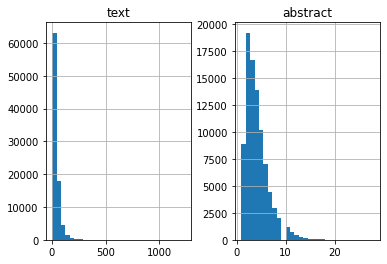

In [18]:

# find the length of sentences in each TEXT / Summay to know the MIN.MAX ranges length
import matplotlib.pyplot as plt

text_word_count = []
abstract_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_abstract']:
      abstract_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'abstract':abstract_word_count})

length_df.hist(bins = 30)
plt.show()

In [19]:
# limit the length of MAX 
max_text_len=30
max_abstract_len=8

In [21]:
# remove the shorter ones than the MAX (max_text_len) limite above
cleaned_text =np.array(data['cleaned_text'])
cleaned_abstract=np.array(data['cleaned_abstract'])

short_text=[]
short_abstract=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_abstract[i].split())<=max_abstract_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_abstract.append(cleaned_abstract[i])
        
df=pd.DataFrame({'text':short_text,'abstract':short_abstract})

In [23]:
# add START and END special tokens (StartTok EndToken)
df['abstract'] = df['abstract'].apply(lambda x : 'sostok '+ x + ' eostok')

In [24]:
# splitting the data 90/10 using train_test_split function
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate=train_test_split(np.array(df['text']),np.array(df['abstract']),test_size=0.1,random_state=0,shuffle=True)

In [25]:
#Text Tokenizer 

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on x_train data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [26]:

# find the least used words by count limit here is 4times
threshold=4 

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
 

In [27]:
x_tokenizer = Tokenizer(num_words=tot_count-count) 

In [28]:
print(tot_count-count)

8466


In [29]:
#prepare a tokenizer for reviews on training data
words_count=tot_count-count #6716
x_tokenizer = Tokenizer(num_words=6716) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences texts_to_sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_validate_seq   =   x_tokenizer.texts_to_sequences(x_validate)

#post padding  zero upto maximum length to unify the sentences lengths   
x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_validate   =   pad_sequences(x_validate_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_vocabulary   =  x_tokenizer.num_words + 1

In [30]:
x_vocabulary

6717

In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [32]:
threshold=6

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
     

In [33]:
words_count=tot_count-count
print(words_count)

1996


In [34]:
#prepare a tokenizer for reviews on training data

words_count=tot_count-count
y_tokenizer = Tokenizer(num_words=words_count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences using texts_to_sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_validate_seq   =   y_tokenizer.texts_to_sequences(y_validate) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_abstract_len, padding='post')
y_validate   =   pad_sequences(y_validate_seq, maxlen=max_abstract_len, padding='post')

#size of vocabulary
y_vocabulary  =   y_tokenizer.num_words +1

In [35]:
y_tokenizer.word_counts['sostok'],len(y_train)

(84924, 42462)

In [36]:
from keras import backend as K
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [37]:
import tensorflow as tf
#K.clear_session()
tf.keras.backend.clear_session()

In [40]:
from tensorflow.keras.layers import Attention
from attention import AttentionLayer

In [41]:
from attention import AttentionLayer

In [42]:
from attention import AttentionLayer
import tensorflow as tf
#K.clear_session()
tf.keras.backend.clear_session()
#

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(30,))

#embedding layer
enc_Embedding =  Embedding(x_vocabulary, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1 
#Return Sequences = True: LSTM produces the hidden state and cell state for every timestep
#Return State = True:LSTM produces the hidden state and cell state of the last timestep only

encoder_lstm01 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output01, state_h01, state_c01 = encoder_lstm01(enc_Embedding)

#encoder_output01 will be used soon as input for next layer

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer /look up from the vocabulary
dec_emb_layer = Embedding(y_vocabulary, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
#Decoder LSTM
decoder_outputs,_, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h01, state_c01])

# add Attention layer
 
# then I have to Concat attention input and decoder LSTM output
 

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model with encoder and decoder 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      671700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    199700      input_2[0][0]                    
______________________________________________________________________________________________

In [43]:
tf.keras.layers.Attention

tensorflow.python.keras.layers.dense_attention.Attention

In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [45]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
es = EarlyStopping(patience=100, monitor='val_loss', restore_best_weights=True) #accuracy, loss, val_loss, val_accuracy

In [ ]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  epochs=2,callbacks=[es],batch_size=128, 
                  validation_data=([x_validate,y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0],y_validate.shape[1], 1)[:,1:]))

Epoch 1/2
 77/332 [=====>........................] - ETA: 1:16 - loss: 4.8881

In [54]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)

In [55]:
model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
          batch_size=32, # 700 / 32 ~= 22    # 8...512
          epochs = 3,
          verbose = 1,  #0,1,2
          validation_data=([x_validate,y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0],y_validate.shape[1], 1)[:,1:]),
          callbacks = [tensorboard_callback, es],
          shuffle = False
          )



Epoch 1/3
1327/1327 [==============================] - 370s 279ms/step - loss: 2.2805 - val_loss: 2.1718
Epoch 2/3
1327/1327 [==============================] - 371s 279ms/step - loss: 2.1013 - val_loss: 2.0748
Epoch 3/3
1327/1327 [==============================] - 290s 218ms/step - loss: 1.9863 - val_loss: 2.0285


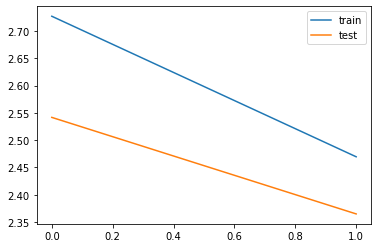

In [56]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()